 # Advanced Lane Finding Project
 
 ## ~ Nalin 

### All imports

In [45]:
import numpy as np
import os
import pickle
import skvideo.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline
import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    print('Existing interference cleared')
    sys.path.remove(path)
    
import cv2 

In [46]:
# ILLUSTRATION CELL: Input image
image = mpimg.imread('test_images/straight_lines1.jpg')

### The Camera class below has all the functions concerned with the camera that include:
#### 1. Function for calibrating the camera.
#### 2. Function for correcting the image due to lens distortion.
#### 3. Function for loading the calibration if the calibration file exists.


In [47]:
class Camera:
    def __init__(self,nx=9,ny=6):
        
        self.nx = nx
        self.ny = ny
        self.flag = False
    
    def calibrate(self, directory, display_result = True):
        print("Process: Calibration | Status: Initiating...")
        
        # Here directory = "camera_cal/"
        imageNames =  os.listdir(directory)
        imagePaths = [ directory + x for x in imageNames]
        
        # create lists to store imagepoints and objectpoints
        objpoints = []
        imgpoints = []
        
        objpts = np.zeros((self.nx*self.ny,3),np.float32)
        objpts[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1,2)
        
        c = 1
        for img_path in imagePaths:
            count = 1
            if display_result == True:
            
                f = plt.figure()
                f.set_figheight(10)
                f.set_figwidth(10)
                
    
            img = mpimg.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)
            
            if ret == True:
                # draw corners onto the image
                draw_img = np.copy(img)
                cv2.drawChessboardCorners(draw_img, (self.nx, self.ny), corners, ret)
                objpoints.append(objpts)
                imgpoints.append(corners)
                
                if display_result == True:
                
                    plt.subplot(1,2,count)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title('Image:'+str(c)+'- Original. No calibration.')

                    plt.subplot(1,2,count+1)
                    plt.imshow(draw_img)
                    plt.axis('off')
                    plt.title('Image:'+str(c)+'- Calibration needed. Corners drawn')
            else:
                if display_result == True:
                    
                    plt.subplot(1,2,count)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title('Image:'+str(c)+'- Original. No calibration.')

                    plt.subplot(1,2,count+1)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title('Image:'+str(c)+'- No calibration needed.')
            c = c + 1 
            count = count + 1
                
            
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1],None,None)
        self.flag = True
        print("Process: Calibration | Status: Complete.")
        
        
        data = {'mtx': self.mtx, 'dist': self.dist}
        pickle.dump(data, open("camera_calibration.p", "wb"))
        print("Process: Calibration | Status: Saved to camera_calibration.p")
        
        
    def undistort(self, image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)
    
    def getCalibration(self, calibration_file = "camera_calibration.p"):
        print("Process: Get Calibration | Status: Loading saved calibration.")
        
        try:
            camera_calibration = pickle.load(open(calibration_file,"rb"))
            self.mtx = camera_calibration['mtx']
            self.dist = camera_calibration['dist']
            print("Process: Get Calibration | Status: Calibration successfully loaded.")
            
        except:
            print("Process: Get Calibration | Status: File not found. | ERROR: No file named " +calibration_file+ " found. Please check if you are loading the correct file." )


Process: Calibration | Status: Initiating...
Process: Calibration | Status: Complete.
Process: Calibration | Status: Saved to camera_calibration.p


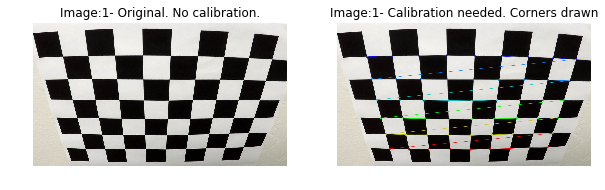

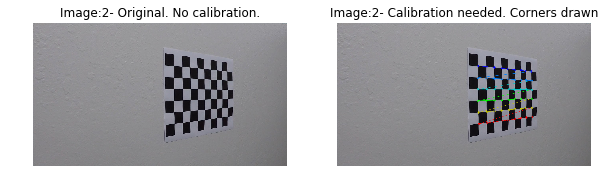

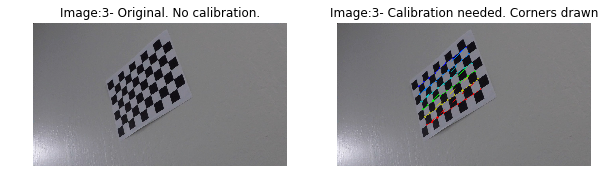

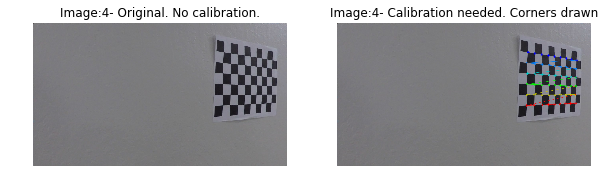

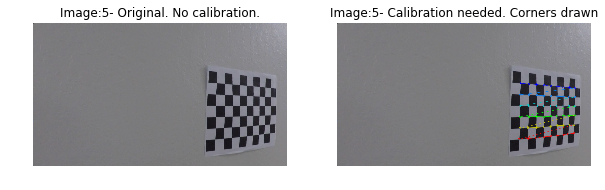

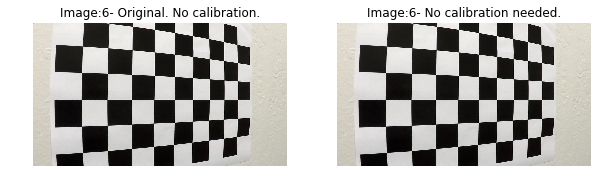

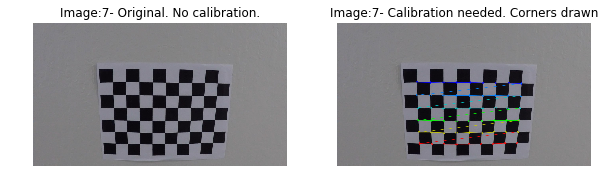

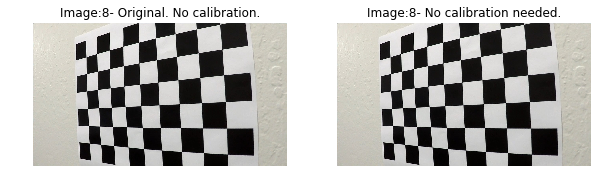

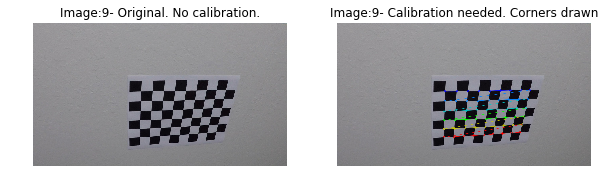

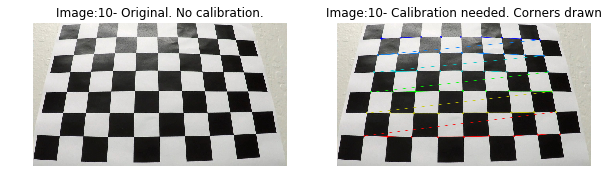

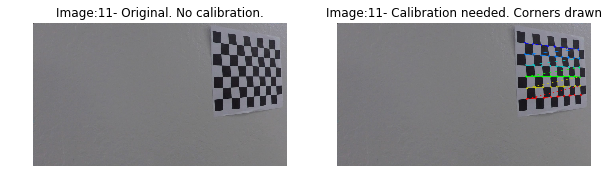

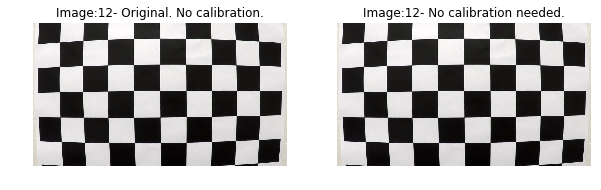

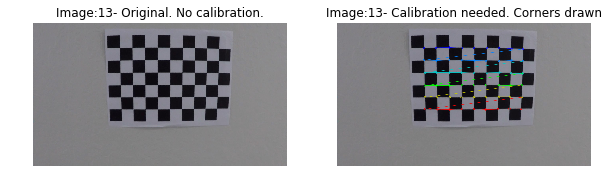

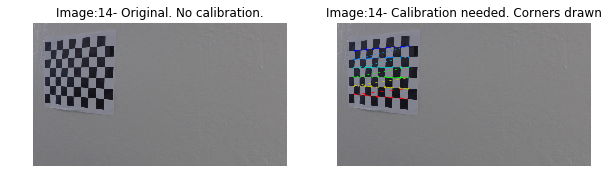

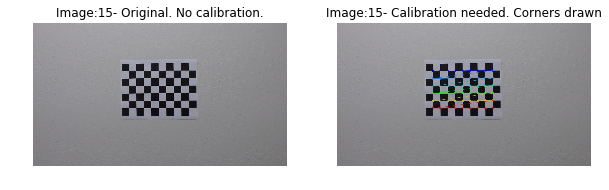

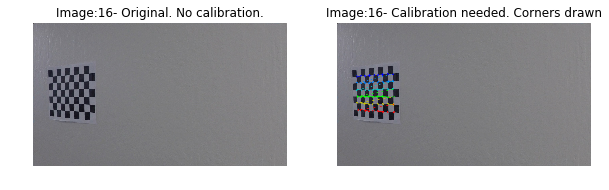

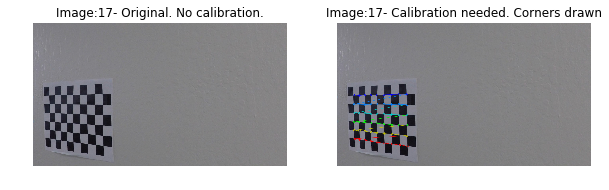

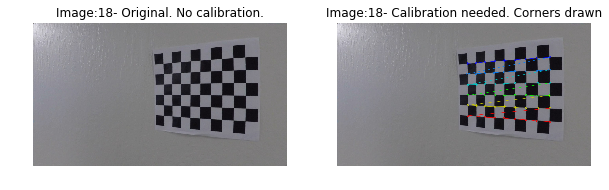

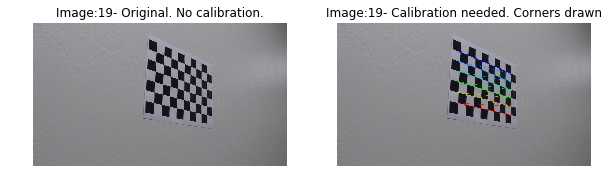

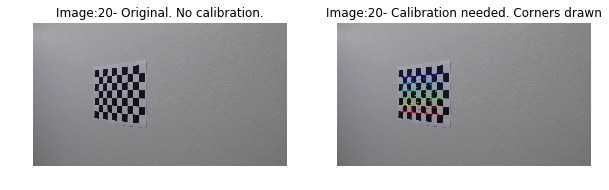

In [48]:
# ILLUSTRATION CEL: CAMERA CALIBRATION AND IMAGE UNDISTORTION
camera = Camera() # create an instance of class camera
camera.calibrate(directory = 'camera_cal/', display_result = True)
undistorted_image = camera.undistort(image)



Text(0.5,1,'Corresponding undistorted Image.')

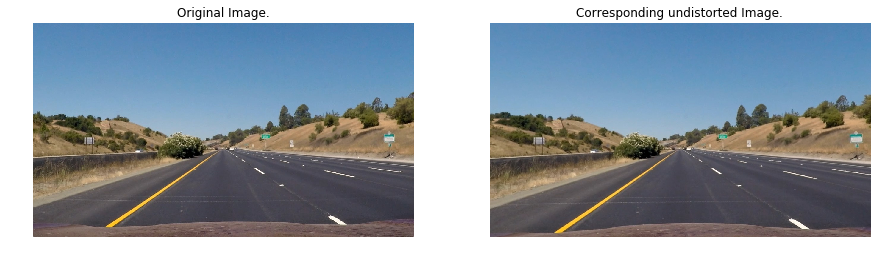

In [49]:
# ILLUSTRATION CELL: DISPLAY ORIGINAL AND UNDISTORTED IMAGES
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image.')
plt.subplot(1,2,2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Corresponding undistorted Image.')

### The Transform class below consists the functions for obtaining a perspective and inverse perspective transform of an image.

In [50]:
class Transform():
    def __init__(self):
        self.image = None
        
    def getPoints(self):
        '''Gets source and destination point'''
        if len(self.image.shape)>2:
            gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        else:
            gray = self.image
            
            
        offset = 75 # offset for dst points
        
        h,w = gray.shape[:2]

        src_pts = np.float32([[w // 2 - offset, h* 0.625], 
                          [w // 2 + offset, h * 0.625], 
                          [offset, h], 
                          [w - offset, h]])

        dst_pts = np.float32([[offset, 0], 
                          [w - offset, 0], 
                          [offset, h], 
                          [w - offset, h]])
        
        return src_pts, dst_pts
    
    def getPerspectiveTransform(self, image):
        '''Gets Perspective transform of an image.'''
        self.image = np.uint8(image)
        src_pts, dst_pts = self.getPoints()
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        img_size = (self.image.shape[1], self.image.shape[0])
        warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_CUBIC)
        return warped
    
    def getInversePerspectiveTransform(self, image):
        '''Gets Inverse Perspective transform of an image.'''
        self.image = np.uint8(image)
        src_pts, dst_pts = self.getPoints()
        M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
        return cv2.warpPerspective(image, M_inv, (self.image.shape[1],self.image.shape[0]),flags=cv2.INTER_CUBIC)
   

Text(0.5,1,'Inverse Perspective Transform on the Warped Image.')

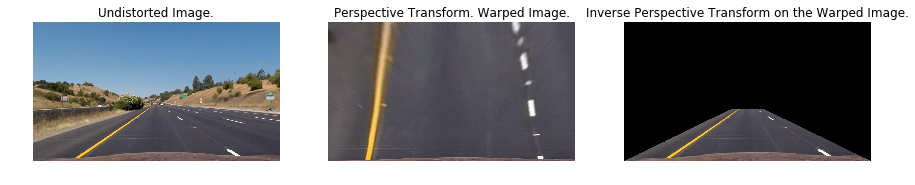

In [51]:
# ILLUSTRATION CELL: PERSPECTIVE TRANSFORM OF UNDISTORTED IMAGE

transform = Transform()
warped_image = transform.getPerspectiveTransform(undistorted_image)
unwarped_image = transform.getInversePerspectiveTransform(warped_image)
fig_1 = plt.figure()
fig_1.set_figheight(15)
fig_1.set_figwidth(15)
plt.subplot(1,3,1)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image.')
plt.subplot(1,3,2)
plt.imshow(warped_image)
plt.axis('off')
plt.title('Perspective Transform. Warped Image.')
plt.subplot(1,3,3)
plt.imshow(unwarped_image)
plt.axis('off')
plt.title('Inverse Perspective Transform on the Warped Image.')



### The Threshold class has functions for all kind of filtering and thresholds including the Sobel filtering and S- Channel (from HLS)filtering. At the end, the class yields a combined Gradient and Color threshold image. 


In [52]:
class Threshold:
    
    def __init__(self):
        self.image = None # np.uint8(image)
            
    def absoluteSobel(self, orient, abs_thresh = (30,100)):
        img = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            x = 1
            y = 0
        else:
            x = 0
            y = 1
            
        sobel = cv2.Sobel(img, cv2.CV_64F, x, y)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
        return grad_binary
        
    def magnitudeSobel(self, sobel_kernel=3, mag_thresh=(30, 100)):
        gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        mag_binary = np.zeros_like(gradmag)
        mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        return mag_binary

    def directionSobel(self, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
        return dir_binary

    def combinedSobel(self):
        gradX = self.absoluteSobel(orient = 'x', abs_thresh = (30,100))
        gradY = self.absoluteSobel(orient = 'y', abs_thresh = (30,100))
        mag_binary = self.magnitudeSobel(sobel_kernel=3, mag_thresh=(30, 100))
        dir_binary = self.directionSobel(sobel_kernel=3, dir_thresh=(0.7, 1.3))
        comb_binary = np.zeros_like(dir_binary)
        comb_binary[((gradX == 1) & (gradY == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        return comb_binary

    def sChannel(self, thresh = (90, 255)):
        hls = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        return s_binary

    def mask(self, threshold):
        img = self.image
        img = np.uint8(255*self.image/np.max(self.image))
        mask = np.zeros_like(img)
        mask[(img>= threshold[0]) & (img <= threshold[1]) ]  = 1
        return mask

    def combinedColorGradient(self, image, threshold = (170, 255), stack = 'False'):
        self.image = np.uint8(255 * image)
        comb_binary = self.combinedSobel()
        s_binary = self.sChannel(threshold)
        
        stack_binary = np.zeros_like(comb_binary)
        stack_binary[(s_binary == 1)| (comb_binary == 1)] = 1
        
        dstack_binary = np.dstack((np.zeros_like(comb_binary), comb_binary, s_binary))
        
        
        if stack == 'False':
            colgrad = stack_binary
        else:
            colgrad = dstack_binary
            
        return np.uint8(colgrad*255)
    
    
        
        
        
        



(A) Undistorted Image (B) Stacked image; the green is the gradient threshold component and the blue is the color channel threshold component. (C) Black and white combined thresholded image - this one has combined both gradient and color thresholds into one image.


Text(0.5,1,'C: Combined Warped Image.')

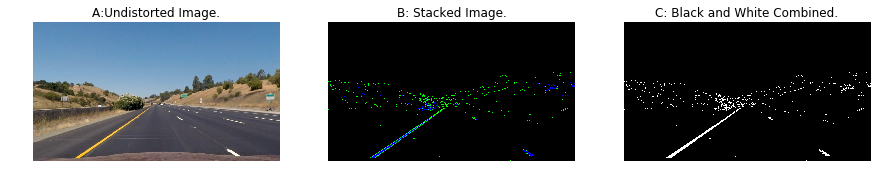

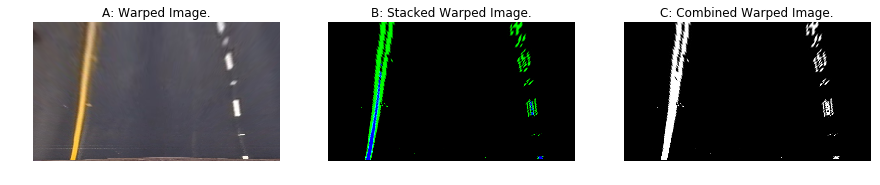

In [53]:
# ILLUSTRATION CELL: THRESHOLDING WITH SOBEL FILTER AND HLS SPACE. THAT IS COMBINED GRADIENT AND COLOR FILTERING.
threshold = Threshold()
combined = threshold.combinedColorGradient(undistorted_image, threshold = (170, 255), stack = 'False')
stacked = threshold.combinedColorGradient(undistorted_image, threshold = (170, 255), stack = 'True')
fig_2 = plt.figure()
fig_2.set_figheight(15)
fig_2.set_figwidth(15)
plt.subplot(1,3,1)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('A:Undistorted Image.')
plt.subplot(1,3,2)
plt.imshow(stacked)
plt.axis('off')
plt.title('B: Stacked Image.')
plt.subplot(1,3,3)
plt.imshow(combined, cmap = 'gray')
plt.axis('off')
plt.title('C: Black and White Combined.')

print('\n(A) Undistorted Image (B) Stacked image; the green is the gradient threshold component and the blue is the color channel threshold component. (C) Black and white combined thresholded image - this one has combined both gradient and color thresholds into one image.')

stacked_warped = transform.getPerspectiveTransform(stacked)
combined_warped = transform.getPerspectiveTransform(combined)
fig_3 = plt.figure()
fig_3.set_figheight(15)
fig_3.set_figwidth(15)
plt.subplot(1,3,1)
plt.imshow(warped_image)
plt.axis('off')
plt.title('A: Warped Image.')
plt.subplot(1,3,2)
plt.imshow(stacked_warped)
plt.axis('off')
plt.title('B: Stacked Warped Image.')
plt.subplot(1,3,3)
plt.imshow(combined_warped, cmap = 'gray')
plt.axis('off')
plt.title('C: Combined Warped Image.')





### Class PixelPoints gets all the pixel points that are possibly for lane lines in the image. After applying Sobel filter in x-direction, edges close to vertical lines are detected. This combined with the HSV space detects colors close to the yellow and white spectrum (We use the HSL space because lane lines are primarily of yellow and white colors)
### The sliding window technique is used to obtain lane pixel points.

In [54]:
class PixelPoints():
    
    def __init__(self):
        
        self.image  = None
        self.nwindows = None
        self.margin = None
        self.min_pix = None
        self.win_height = None
        
        self.win_y_low = None
        self.win_y_high = None
        self.win_xleft_low = None
        self.win_xleft_high = None
        self.win_xright_low = None
        self.win_xright_high = None
        
        
        
        self.left_lane_inds = None
        self.right_lane_inds = None
        
    def generateCorners(self, window, leftx_current, rightx_current):
        self.win_y_low = self.image.shape[0] - (window+1)*self.win_height
        self.win_y_high = self.image.shape[0] - window*self.win_height


        self.win_xleft_low = leftx_current - self.margin
        self.win_xleft_high = leftx_current + self.margin
        self.win_xright_low = rightx_current - self.margin
        self.win_xright_high = rightx_current + self.margin
        
    def visualizeWindows(self, out_img, nonzerox, nonzeroy):
        
        cv2.rectangle(out_img,(self.win_xleft_low,self.win_y_low),(self.win_xleft_high,self.win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(self.win_xright_low,self.win_y_low),(self.win_xright_high,self.win_y_high),(0,255,0), 2)
        return out_img
        
        
        
    def getPixelPoints(self, image, nwindows, margin, min_pix, visualizeWindows = False):
        self.image = image
        self.nwindows = nwindows
        self.margin = margin
        self.min_pix= min_pix
        self.win_height = np.int(image.shape[0]//nwindows)
        
        
        gray = cv2.cvtColor(np.uint8(self.image), cv2.COLOR_RGB2GRAY)
        histogram = np.sum(gray[self.image.shape[0]//2:,:], axis=0)
       
          
        midpoint = np.int(histogram.shape[0]//2)
                
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        
        # Identify the x and y positions of all nonzero pixels in the image
        self.image = cv2.GaussianBlur(self.image, (3, 3), 0)
        nonzero = self.image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []
        out_img = np.copy(self.image)
        out = np.copy(self.image)
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            self.generateCorners(window, leftx_current, rightx_current)
            
            
            if visualizeWindows == True:
                out_img = self.visualizeWindows(out_img, nonzerox, nonzeroy)
                
            
            # Identify the nonzero pixels in x and y within the windows
            good_left_inds = ((nonzeroy >= self.win_y_low) & (nonzeroy < self.win_y_high) & (nonzerox >= self.win_xleft_low) &  (nonzerox < self.win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= self.win_y_low) & (nonzeroy < self.win_y_high) & (nonzerox >= self.win_xright_low) &  (nonzerox < self.win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.min_pix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.min_pix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
                 
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            self.left_lane_inds = np.concatenate(self.left_lane_inds)
            self.right_lane_inds = np.concatenate(self.right_lane_inds)
        except ValueError:
        # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        out[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255,0,0]
        out[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0,0,255]
        
        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [0,0,0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0,0,0]
        final = overlay = cv2.addWeighted(out_img,1,out,0.8,0)
        
        points= out_img
        points[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255,255,255]
        points[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [255,255,255]

        return leftx, lefty, rightx, righty, final, points, histogram
    


Text(0.5,1,'B: Left Lane Line = Red, Right Lane Line = Blue')

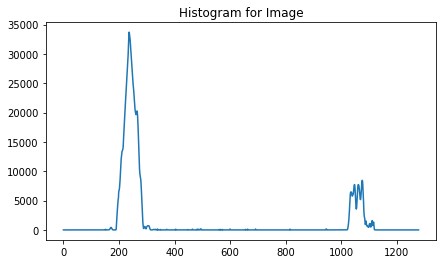

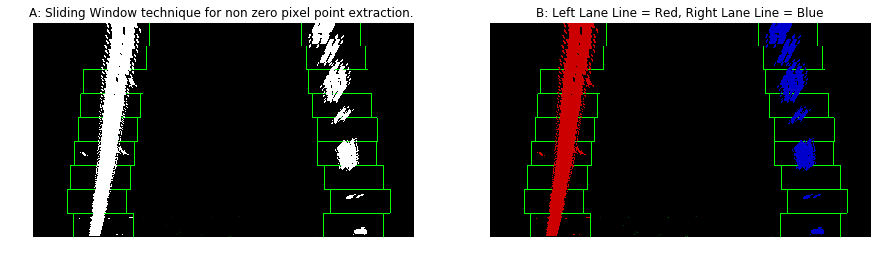

In [55]:
# ILLUSTRATION CELL: SLIDING WINDOW TECHNIQUE FOR LANE LINE PIXEL POINT EXTRACTION

pp = PixelPoints()
leftx, lefty, rightx, righty, final, out_img, histogram = pp.getPixelPoints(stacked_warped, 9, 100, 50, visualizeWindows = True)

fig_4 = plt.figure()
fig_4.set_figheight(4)
fig_4.set_figwidth(7)
plt.plot(histogram)
plt.title('Histogram for Image')


fig_5 = plt.figure()
fig_5.set_figheight(15)
fig_5.set_figwidth(15)
plt.subplot(1,2,1)
plt.imshow(out_img, cmap = 'gray')
plt.axis('off')
plt.title('A: Sliding Window technique for non zero pixel point extraction. ')
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title('B: Left Lane Line = Red, Right Lane Line = Blue')


### The FitPolynomial class has functions that fit a polynomial curve to the extracted lane line pixel points and also returns a lane. 

In [56]:
class FitPolynomial():
    
    def __init__(self):
        self.image = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None #np.polyfit(lefty, leftx, 2)
        self.right_fit = None #np.polyfit(righty, rightx, 2)
        self.img_shape = None
    
    def polyFit(self, leftx, lefty, rightx, righty):
        # Find our lane pixels first
        #leftx, lefty, rightx, righty, out_img = self.slideWindow(self.image)
        img_shape = self.img_shape
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        #out_img[lefty, leftx] = [255, 0, 0]
        #out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        

        return left_fitx, right_fitx, ploty
    
    def aroundPoly(self, image, leftx, lefty, rightx, righty):
        self.image = image
        self.img_shape = self.image.shape
        self.leftx = leftx
        self.lefty = lefty
        self.rightx = rightx
        self.righty = righty
        
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        margin = 100
        
        
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

        # Grab activated pixels
        nonzero = self.image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                    self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                    self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                    self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                    self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = self.polyFit(leftx, lefty, rightx, righty)
        
       
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.copy(self.image * 255) #np.dstack((self.image, self.image, self.image))*255
        window_img = np.zeros_like(self.image)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        
        
        # Draw the lane line margin onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        polynomial = cv2.addWeighted(window_img, 0.3, out_img, 1, 0)

        #--------------------------------------------------------------------------------------------------
        warp_zero = np.zeros_like(self.image).astype(np.uint8)
        #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
        lane = warp_zero
        #--------------------------------------------------------------------------------------------------
        #polynomial = plt.figure()
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        plot = (left_fitx, right_fitx, ploty)
        return polynomial, lane, (leftx, lefty, rightx, righty),plot

  

Text(0.5,1,'B: Lane in Green')

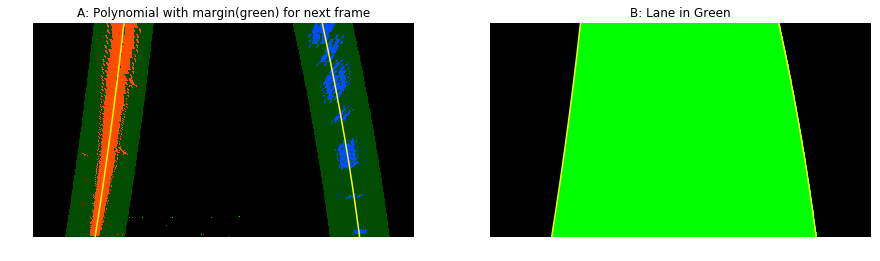

In [57]:
# ILLUSTRATION CELL: FITTING POLYNOMIAL CURVE. EXTRACTING POINTS WITHOUT WINDOW SEARCH AND LANE OVERLAY.

polyfit = FitPolynomial()
polynomial, lane, _, plot= polyfit.aroundPoly(stacked_warped, leftx, lefty, rightx, righty)

fig_6 = plt.figure()
fig_6.set_figheight(15)
fig_6.set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(plot[0], plot[2], color = 'yellow')
plt.plot(plot[1], plot[2], color = 'yellow')
plt.imshow(polynomial)
plt.axis('off')
plt.title('A: Polynomial with margin(green) for next frame')
plt.subplot(1,2,2)
plt.plot(plot[0], plot[2], color = 'yellow')
plt.plot(plot[1], plot[2], color = 'yellow')
plt.imshow(lane)
plt.axis('off')
plt.title('B: Lane in Green')

### The Pipeline class processes a single image, a video, and runs a test on test images to check if the pipeline works.

In [58]:
class Pipeline():
    def __init__(self):
        "Initializing instances for al the classes"
        files = os.listdir('./')
        calib_file = 'camera_calibration.p'
        self.camera = Camera()
        self.display = False
        if calib_file not in files:
            self.camera.calibrate(directory = 'camera_cal/', display_result = False)
        self.camera.getCalibration()
        self.threshold = Threshold()
        self.transform = Transform()
        self.pixelpoints = PixelPoints()
        self.polyfit = FitPolynomial()
        
        # For Video -------------------------------------
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        
    def reset(self):
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        
    def overlay(self, undist_img, lane_image):
        #warped = self.transform.getPerspectiveTransform(undist_img)
        #final = cv2.addWeighted(warped, 1, lane_image, 1, 0)
        unwarped = self.transform.getInversePerspectiveTransform(lane_image)
        final = cv2.addWeighted(undist_img, 1, unwarped, 1, 0)
        return final
        
        
    def processImage(self, image):
        undist_image = self.camera.undistort(image)
        threshold_image = self.threshold.combinedColorGradient(undist_image, threshold = (170,255), stack= 'True')
        warped = self.transform.getPerspectiveTransform(threshold_image)
        self.reset()
        leftx, lefty, rightx, righty, final, out_img, histogram = self.pixelpoints.getPixelPoints(warped, 9, 150, 50, False)
        result, lane, predicted_corners, _ = self.polyfit.aroundPoly(warped, leftx, lefty, rightx, righty)
        final = self.overlay(undist_image, lane)
        return final, predicted_corners
        
        
        
    def processVideo(self, video, output_video):
        print("Process: Advanced Lane Detection for video. | Status: Initiated...")
        print("Process: Advanced Lane Detection for video. | Status: Parsing through each frame...")
        output_video = './' + output_video+ '.mp4'
        count_frame = 0
       
        
        
        videogen = skvideo.io.vreader(video)#skvideo.datasets.bigbuckbunny())
        count = 0
        for frame in videogen:
            count = count + 1 
            if count == 1:
                height, width, layers = frame.shape
                final, predicted_corners = self.processImage(frame)
                self.leftx = predicted_corners[0]
                self.lefty = predicted_corners[1]
                self.rightx = predicted_corners[2]
                self.righty = predicted_corners[3]
                #video = cv2.VideoWriter(output_video, -1, 1, (width,height))
                writer = skvideo.io.FFmpegWriter(output_video)
                writer.writeFrame(final)
                #video.write(final)
            elif count>1:
                undist_image = self.camera.undistort(frame)
                threshold_image = self.threshold.combinedColorGradient(undist_image, threshold = (170,255), stack= 'True')
                warped = self.transform.getPerspectiveTransform(threshold_image)
                _, lane, predicted_corners, _ = self.polyfit.aroundPoly(warped, self.leftx, self.lefty, self.rightx, self.righty)
                self.leftx = predicted_corners[0]
                self.lefty = predicted_corners[1]
                self.rightx = predicted_corners[2]
                self.righty = predicted_corners[3]
                final = self.overlay(undist_image, lane)
                writer.writeFrame(final)
        writer.close()
        print("Process: Advanced Lane Detection for video. | Status: Completed. Video Saved as:"+output_video)
        
        
    def runTest(self):
        directory = 'test_images/'
        imageNames =  os.listdir(directory)
        imagePaths = [ directory + x for x in imageNames]
        count = 0
        print('Process: Test run. | Status: Initiated.')

        for path in imagePaths:
            count = count + 1
            image = mpimg.imread(path)
            overlay, _  = pipeline.processImage(image)

            fig_ = plt.figure()
            fig_.set_figheight(10)
            fig_.set_figwidth(10)

            plt.subplot(1,2,1)
            plt.imshow(image)
            plt.axis('off')
            plt.title('Original Image_'+str(count))

            plt.subplot(1,2,2)
            plt.imshow(overlay)
            plt.axis('off')
            plt.title('Advanced Lane Detection Image_'+str(count))

            mpimg.imsave('output_images/test'+str(count), overlay)
        print('Process: Test run. | Status: Test images saved.')
          

Process: Get Calibration | Status: Loading saved calibration.
Process: Get Calibration | Status: Calibration successfully loaded.


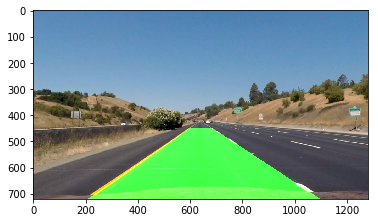

In [59]:
# ILLUSTRATION CELL: FINAL PROCESSED IMAGE
image =mpimg.imread('test_images/straight_lines1.jpg')
pipeline = Pipeline()
overlay, _  = pipeline.processImage(image)
plt.imshow(overlay)

In [60]:
# PROCESSING VIDEO
pipeline = Pipeline()
video = 'project_video.mp4'
output_video = 'project_video_output'
pipeline.processVideo(video, output_video)

Process: Get Calibration | Status: Loading saved calibration.
Process: Get Calibration | Status: Calibration successfully loaded.
Process: Advanced Lane Detection for video. | Status: Initiated...
Process: Advanced Lane Detection for video. | Status: Parsing through each frame...
Process: Advanced Lane Detection for video. | Status: Completed. Video Saved as:./project_video_output.mp4


Process: Get Calibration | Status: Loading saved calibration.
Process: Get Calibration | Status: Calibration successfully loaded.
Process: Test run. | Status: Initiated.
Process: Test run. | Status: Test images saved.


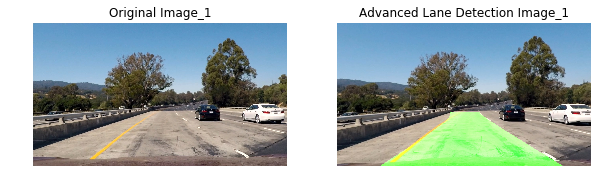

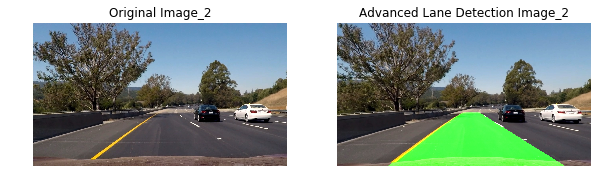

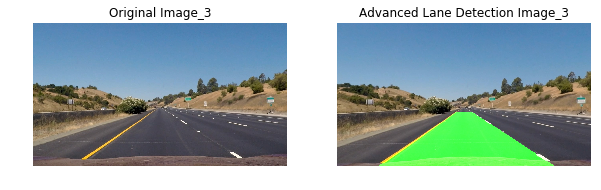

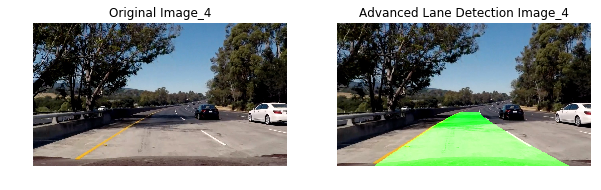

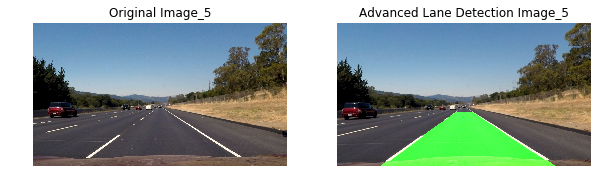

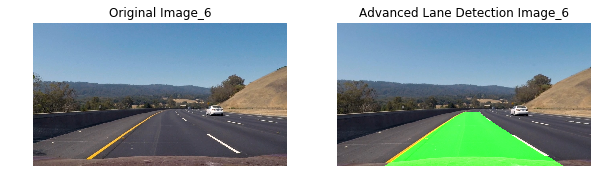

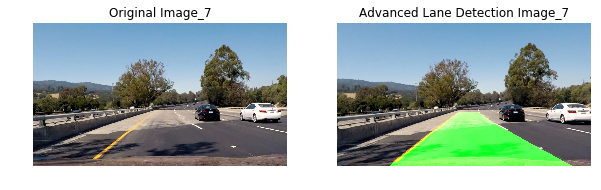

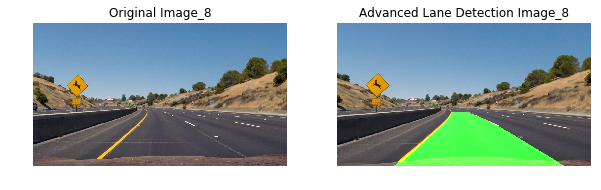

In [44]:
# PROCESSING TEST
pipeline = Pipeline()
pipeline.runTest()